In [1]:
## newer
## 2022_Leaf_rewrite-for-model-benchmark-forConvert2Py-reloadModelTestAcc.py
##

2020-09-01 LSW@NCHC

Load the trained model and inference test-dataset.

* dataset是否來自同一機台同一機型

* 以假定dataset分類規則是合理的


## <font color=blue>Install packages</font>

In [68]:
!sh install_env.sh

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease   
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [1421 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [1362 kB]
Fetched 3035 kB in 4s (794 kB/s)                      
Reading package lists... Done
Building dependency tree       
Reading state information... Done
56 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsm6 is already the newest version (2:1.2.2-1).
libxext-dev is already the newest version (2:1.3.3-1).
libxrender1 is already the newest version (1:0.9.10-1).
tree is already the newest version (1.7.0-5).
unrar is alre

## <font color=#FF6600>1. Download dataset</font> 

In [70]:
import tensorflow as tf

# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import cv2
import vlogging
import seaborn as sns

print("tf version : ", tf.__version__)

# test dataset path
pre_list = '/home/u3148947/.keras/datasets/0728_jpgTestingSet/'
d_list = ['19CC2018-02-00',  '19CJ2029-02-00',  '19CJ2029-04-00']

test_data_dir = pre_list + d_list[2]
test_data_dir = pathlib.Path(test_data_dir) 
# For only one classes
# test_data_dir_root = pre_list + d_list[1]
# test_data_dir = pathlib.Path(test_data_dir_root + '/ng') # 注意！這把原本路徑轉換成PosixPath的物件=PosixPath('~/user/.keras/datasets/')不是原始的string路徑。

image_count = len(list(test_data_dir.glob('*/*.jpg')))
# For only one classes
# image_count = len(list(test_data_dir.glob('*.jpg')))

CLASS_NAMES = np.array([item.name for item in test_data_dir.glob('*') if item.name != "LICENSE.txt" and not item.name.startswith('.')])
# For only one classes
# class_names = np.array(sorted([item.name for item in pathlib.Path(test_data_dir_root).glob('*') if item.name != "LICENSE.txt" and not item.name.startswith('.')]))



# data information
print("Save to :", test_data_dir)
print("Count images: ", image_count)
print("Class names : ", class_names)

# vars
BATCH_SIZE = 32
img_height = 224
img_width = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

#IMG_SIZE = (224, 224) # IMG_SIZE = (160, 160)

tf version :  2.2.0
Save to : /home/u3148947/.keras/datasets/0728_jpgTestingSet/19CJ2029-04-00
Count images:  9235
Class names :  ['ng' 'ok']


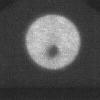

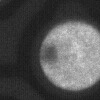

In [47]:
# 檢查資料夾內圖片

roses = list(test_data_dir.glob('*/*'))
# For only one classes
# roses = list(test_data_dir.glob('*'))

for image_path in roses[:2]:
    display.display(Image.open(str(image_path)))

## <font color=#FF6600>2. Load dataset with tf.data</font>

In [50]:
list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*/*'), shuffle=False)
# For only one classes
# list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [51]:
# 檢查路徑、檔案

for f in list_ds.take(10):
  print(f.numpy())

b'/home/u3148947/.keras/datasets/0728_jpgTestingSet/19CJ2029-04-00/ok/CSPAFI#4_19CJ2029-04-000_1_NG003_Panel0006_ProcA4_Shot0_V28_D0_Img.bmp.jpg'
b'/home/u3148947/.keras/datasets/0728_jpgTestingSet/19CJ2029-04-00/ok/CSPAFI-C#3_19CJ2029-04-000_1_NG008_Panel0006_ProcA3_Col#1_Shot0_V17_D0_Img.bmp.jpg'
b'/home/u3148947/.keras/datasets/0728_jpgTestingSet/19CJ2029-04-00/ok/CSPAFI#4_19CJ2029-04-000_1_NG002_Panel0010_ProcA3_Shot0_V3_D0_Img.bmp.jpg'
b'/home/u3148947/.keras/datasets/0728_jpgTestingSet/19CJ2029-04-00/ng/CSPAFI#4_19CJ2029-04-000_1_NG003_Panel0013_ProcA4_Shot0_V0_D3_Img.bmp.jpg'
b'/home/u3148947/.keras/datasets/0728_jpgTestingSet/19CJ2029-04-00/ok/CSPAFI-C#3_19CJ2029-04-000_1_NG005_Panel0021_ProcA4_Col#2_Shot0_V22_D0_Img.bmp.jpg'
b'/home/u3148947/.keras/datasets/0728_jpgTestingSet/19CJ2029-04-00/ok/CSPAFI-C#3_19CJ2029-04-000_1_NG003_Panel0003_ProcA4_Col#2_Shot0_V15_D1_Img.bmp.jpg'
b'/home/u3148947/.keras/datasets/0728_jpgTestingSet/19CJ2029-04-00/ok/CSPAFI-C#3_19CJ2029-04-000_1_NG0

In [52]:
test_ds = list_ds
print(tf.data.experimental.cardinality(test_ds).numpy())

9235


### Converts a file path to an (img, label) pair:

In [53]:
#J modify the get_label for runing at tf2.2 2020-08-06 2020-08-11 OKfortf2.2
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
#     print('one_num:', one_num)
    # Integer encode the label
    return one_num
#     return tf.argmax(one_hot)
#   return tf.math.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


In [54]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
test_ds_map = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [55]:
# Cehck ds's label
for image, label in test_ds_map.take(10):
  print("Image shape: ", image.numpy().shape)
#   print("Image path : ", image)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  0
Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  0
Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  1


In [56]:
def configure_for_performance_cache(ds, cache=True):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
      print("Check cache to file:", cache)
    else:
      ds = ds.cache()
      print("Check cache in memory:", cache)
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [57]:
#J 新版：
test_ds_pre = configure_for_performance_cache(test_ds_map)

Check cache in memory: True


### Visualize the data
You can visualize this dataset similarly to the one you created previously.

label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)


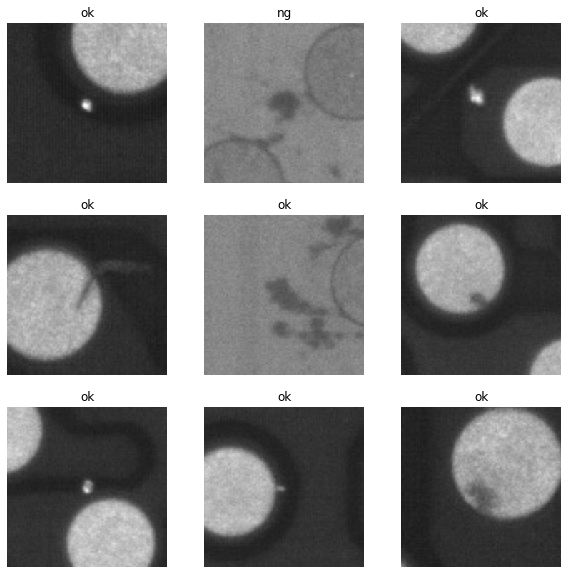

In [61]:
image_batch, label_batch = next(iter(test_ds_pre))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  print('label from label_batch:', label)
  plt.title(class_names[label])
  plt.axis("off")

## <font color=#FF6600>3. Load trained model and inference test-data</font>

In [62]:
# Loading the model back
current_model_name = 'uni-cj0713-tf22-ren50-e60-20200831.h5'
model_back = tf.keras.models.load_model(current_model_name)

In [63]:
%%time
test_dataset = test_ds_pre
print("test size : ", image_count)
print("test_data_dir : ", test_data_dir)


loss, accuracy = model_back.evaluate(test_dataset)
print('Test accuracy :', accuracy)


test size :  9235
test_data_dir :  /home/u3148947/.keras/datasets/0728_jpgTestingSet/19CJ2029-04-00
289/289 [==============================] - 9s 31ms/step - loss: 4.2330 - accuracy: 0.6330
Test accuracy : 0.6330265402793884
CPU times: user 13.9 s, sys: 9.27 s, total: 23.1 s
Wall time: 11.9 s


### results

current_model_name = 'uni-cj0713-tf22-ren50-e60-20200831.h5' 


* 從lisd_ds計算有誤，請用ds batch!!!!!!!

* 1

19CC2018-02-00/ALL 5545
Test accuracy : 0.6250676512718201 (0.86 + 0.38 /2 =0.62)

19CC2018-02-00/ng 62
Test accuracy : 0.8548386693000793

19CC2018-02-00/ok 5483
Test accuracy : 0.3775305449962616


* 2

19CJ2029-02-00/ALL 13481
Test accuracy : 0.5889770984649658

ng 419
Test accuracy : 0.7374702095985413

ok 13062 
Test accuracy : 0.4157862365245819

* 3

19CJ2029-04-00/ALL 9235
Test accuracy : 0.6330265402793884

ng 792 
Test accuracy : 0.6351010203361511   , ~503 images 符合cm結果

ok 8443
Test accuracy : 0.3671680688858032   , ~3100 images 符合cm結果

In [40]:
import pandas as pd
data={"Accuracy":[0.625,0.854,0.377,
                  0.588, 0.737, 0.415,
                  0.633, 0.635, 0,
                 ],
      "Images":[5545,62,5483,
                13481,0,0,
               9235,0,0,
               ]}
df=pd.DataFrame(data,index=["19CC2018-02-00/ALL","19CC2018-02-00/ng","19CC2018-02-00/ok",
                            "19CJ2029-02-00/ALL","19CJ2029-02-00/ng","19CJ2029-02-00/ok",
                           "19CJ2029-04-00/ALL","19CJ2029-04-00/ng","19CJ2029-04-00/ok",] )

In [17]:
df

,Accuracy,Images
19CC2018-02-00/ALL,0.625,5545
19CC2018-02-00/ng,0.854,62
19CC2018-02-00/ok,0.377,5483
19CJ2029-02-00/ALL,0.588,13481
19CJ2029-02-00/ng,0.737,0
19CJ2029-02-00/ok,0.415,0
19CJ2029-04-00/ALL,0.633,9235
19CJ2029-04-00/ng,0.635,0
19CJ2029-04-00/ok,0.000,0


### Check prediction 1 : from tf.dataset with single image

In [123]:
# from tensorflow import keras

# #sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# #sunflower_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Sunflower_sky_backdrop.jpg/1024px-Sunflower_sky_backdrop.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# img = keras.preprocessing.image.load_img(
#     sunflower_path, target_size=(img_height, img_width)
# )
# img_array = keras.preprocessing.image.img_to_array(img)


image_batch, label_batch = next(iter(test_ds_pre))

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)cc
#   plt.imshow(image_batch[i].numpy().astype("uint8"))
#   label = label_batch[i]
#   print('label from label_batch:', label)
#   plt.title(class_names[label])
#   plt.axis("off")


# img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = tf.expand_dims(image_batch[0], 0) # Create a batch

predictions = model_back.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(
    "True label: {} , prediction label: {}".format(label_batch[0], np.argmax(score))
)

This image most likely belongs to ok with a 100.00 percent confidence.
True label: 1 , prediction label: 1


In [15]:
predictions[0]

array([ 4.440949, -5.651328], dtype=float32)

In [16]:
label_batch[0]

<tf.Tensor: shape=(), dtype=int64, numpy=0>

### Check prediction 1v2 : from tf.dataset  with Batch images

In [64]:
%%time
# rewrite to prediction with batch of ds, replace the list of file to speed up.
# todo: Checked right!:model_back.predict_on_batch [OK done 20200904]

batch_n = 0
acc_count= 0

label_true_all = []
label_pred_all = []

for image_batch, label_batch in test_ds_pre: #ds set to repeat forever
    batch_n += 1
    pred_max = []
    pred = model_back.predict_on_batch(image_batch)
    
    label_batch_np = label_batch.numpy()
    label_true_all.extend(label_batch_np)
    print('label_batch_np = ',label_batch_np)
    
    for i in range(BATCH_SIZE):
#         print(i)
        try:
            score = tf.nn.softmax(pred[i])
            label_pred = np.argmax(score)
            pred_max.append(label_pred)
            
#             print('label_batch_np[i] = ', label_batch_np[i])
            
            if label_batch_np[i] == label_pred:
                acc_count += 1
        except IndexError:
            print("End of batch")
    label_pred_all.extend(pred_max)
    
    print("pred =", pred_max)
print("acc_count =", acc_count, "  (if score == label[i] then count one.)") 
print("Number of batch used = ",batch_n)


label_batch_np =  [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1]
pred = [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]
label_batch_np =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
pred = [1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
label_batch_np =  [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
pred = [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]
label_batch_np =  [1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]
pred = [0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]
label_batch_np =  [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
pred = [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1]
label_batch_np =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [120]:
label_pred_all

[1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,


In [121]:
label_true_all

[1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [65]:
len(label_true_all)

9235

In [66]:
len(label_pred_all)

9235

In [34]:
# label_pred_all_resp = np.reshape(label_pred_all, -1, order='C')

In [35]:
# label_true_all_resp = np.reshape(label_pred_all, -1, order='C')

### confusion_matrix

tf.Tensor(
[[ 503  289]
 [3100 5343]], shape=(2, 2), dtype=int32)
2
[0 1]


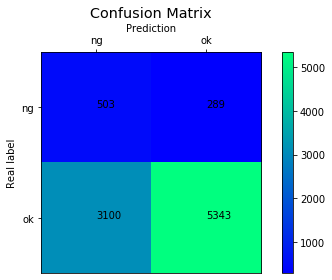

In [117]:
# Plot confusion matrix with matplotlib

confusion_matrix = tf.math.confusion_matrix(label_true_all, label_pred_all, num_classes=2)
print(confusion_matrix)

classes = class_names
print(len(classes))

def plot_confusion_matrix(confusion_matrix):
    # Let label of xticks go to top
    fig, ax = plt.subplots()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.winter)
    plt.title('Confusion Matrix', fontsize='x-large')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    print(tick_marks)
    plt.xticks(tick_marks, classes)#, rotation=-45)
    plt.yticks(tick_marks, classes)


    iters = [[i,j] for i in range(len(classes)) for j in range(len(classes))]
    for i, j in iters:
        plt.text(j, i, format(confusion_matrix[i, j]))

    plt.ylabel('Real label')
    plt.xlabel('Prediction')
    plt.tight_layout()
    plt.show()

    
plot_confusion_matrix(confusion_matrix)

tf.Tensor(
[[ 503  289]
 [3100 5343]], shape=(2, 2), dtype=int32)
2


Text(0.5, 1.0781824871228844, 'Confusion Matrix')

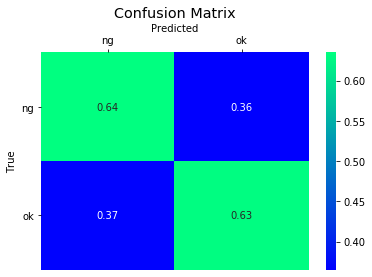

In [122]:
# Plot confusion matrix with seaborn

cm = tf.math.confusion_matrix(label_true_all, label_pred_all, num_classes=2)
print(cm)

classes = class_names
print(len(classes))

cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

# Let label of xticks go to top
fig, ax = plt.subplots()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')


sns.heatmap(
    cm, annot=True,cmap=plt.cm.winter,
    xticklabels=classes,
    yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")

# Let y-label also matching matplotlib
plt.yticks(rotation=0)
plt.title('Confusion Matrix', fontsize='x-large')

### Check prediction 2 : from image list

### 有bug counting 數與ds算法不一致 待解決

In [ ]:
%%time

# from tensorflow import keras
from decimal import Decimal

# Loading the model back
current_model_name = 'uni-cj0713-tf22-ren50-e60-20200831.h5'
model_back = tf.keras.models.load_model(current_model_name)

# list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*/*'), shuffle=False)
# For only one classes
list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*'), shuffle=False)



count = 0
pred = 0
for path in list_ds:
    img = tf.keras.preprocessing.image.load_img(
    path.numpy(), target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model_back.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    true_label = get_label(path.numpy())
    
    print(
    "{}: True label: {} , prediction label: {}".format(path, true_label, np.argmax(score))
    )

    if np.argmax(score) == true_label:
        pred += 1
    count += 1
print("test image count = ", count)
print("Whole imgs count = ", tf.data.experimental.cardinality(test_ds).numpy())
print("pred(to 0) count = ", pred)

print("Accuracy = ", (pred / count))


In [26]:
print("Accuracy = ", 508/ 800)

Accuracy =  0.635


In [ ]:
#NOTE2020-09-03
test image count =  792
Whole imgs count =  792
pred(to 0) count =  508
Accuracy = % 0.6414141414141414 (pred from list 錯誤) 
    model.evaluate()是使用batch_size的的整數當分母 ACC=0.6351010203361511 (假設錯誤)
    792/32= = 24.75
    25*32= 800
    508 / 800 = 0.6351010203361511 #又因為程式語言使用二進制轉換回十進制導致浮點數不齊
    
    # Check by rewirte ds and the batch_predict (正確)
    acc_count = 503
    503 /792 = 0.63510101010101

    
test image count =  419
Whole imgs count =  419
pred(to 0) count =  307
Accuracy =  0.7326968973747017 (pred from list 錯誤)   
    model.evaluate()是使用batch_size的的整數當分母 ACC=0.7374702095985413 (假設錯誤)
    419 /32 =  13.09375
    13*32 = 416
    14*32 = 448
    307 / 416 = 0.7379807692307692
    307 / 448 = 0.6852678571428571
    13.1*32 = 419.2
    307/ 419.2 = 0.7323473282442748
    
    
    # Check by rewirte ds and the batch_predict  (正確)
    acc_count = 309   (if score == label[i] then count one.)
    Number of batch used =  14
    CPU times: user 763 ms, sys: 85.9 ms, total: 849 ms
    Wall time: 645 ms
        
    acc_count = 309
    309 / 419 = 0.737470167064439


* dataset是否來自同一機台同一機型

* 以假定dataset分類規則是合理的

In [47]:
#labels for the scalar outputs of evaluate

model_back.metrics_names

['loss', 'accuracy']